In [41]:
"""To extract features of a face from trained network"""

import torch
from torch.autograd import Variable
import torch.functional as F
import dataLoader
import argparse
import torch.optim as optim
import torchvision.utils as vutils
from torch.utils.data import DataLoader
import faceNet
import torch.nn as nn
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# do not change seed value
np.random.seed(11)
torch.random.manual_seed(11)

In [45]:
batch_size = 10
m = 4
model = "../cosFace/checkpoint/netFinal_8.pth"
imWidth = 96
imHeight = 112
imageRoot = "/datasets/cse152-252-sp20-public/hw2_data/CASIA-WebFace/"
alignmentRoot = "./data/casia_landmark.txt"

In [46]:
# Initialize dataLoader
faceDataset = dataLoader.BatchLoader(
        imageRoot = imageRoot,
        alignmentRoot = alignmentRoot,
        cropSize = (imWidth, imHeight ),
        shuffle = False)
faceLoader = DataLoader(faceDataset, batch_size = batch_size, num_workers = 16, shuffle = False )


In [47]:
net = faceNet.faceNet(m = m, feature = True )
net.load_state_dict(torch.load(model, map_location=torch.device('cpu')) )
# net.cuda()
net.eval()
feature_ids = []
features_array = None

for i, dataBatch in enumerate(faceLoader):
    # Read data
    if dataBatch['target'][0].item() == 10:
        break
    image_cpu = dataBatch['img']
    imBatch = Variable(image_cpu )
#     imBatch = imBatch.cuda()
    feature = net.forward_with_normalization(imBatch)
    feature = feature.detach().cpu().numpy()
    if features_array is None:
        features_array = feature
    else:
        features_array = np.vstack((features_array,feature))
    ids = dataBatch['target'].tolist()
    feature_ids = feature_ids + [val for sublist in ids for val in sublist]

print(features_array.shape)
feature /= np.linalg.norm(feature, axis = 1).reshape((10,1))
# print(np.sum(feature**2, axis = 1))

features_array = features_array[:-1]
feature_ids = feature_ids [:-1]

(1340, 512)


In [48]:
# feature_ids[-2:]
# print(features_array.shape)
# # to remove id = 10 entries
# for i, idx in reversed(list(enumerate(feature_ids))):
#     print(i, idx)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


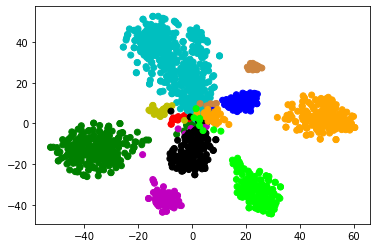

In [56]:
feature_embedded = TSNE(n_components=2).fit_transform(features_array)


color_map = {
    0: 'r',
    1: 'g',
    2: 'b',
    3: 'c',
    4: 'm',
    5: 'y',
    6: 'k',
    7: 'peru',
    8: 'orange',
    9: 'lime',
    
}

# n_samples = feature_embedded.shape[0]
# x = np.linspace(0, 1, int(np.sqrt(n_samples))+1)
# xx, yy = np.meshgrid(x, x)
# X = np.hstack([
#     xx.ravel().reshape(-1, 1),
#     yy.ravel().reshape(-1, 1),
# ])
# color = xx.ravel()
# color = color[:n_samples]
plt.plot(figsize=(15, 8))
ax = plt.subplot(111)
ax.scatter(feature_embedded[:, 0], feature_embedded[:, 1], c=[color_map[i] for i in feature_ids])

plt.savefig("./results/tsne_cos_bn.png")